# Лабораторная работа № 5
## Часть 1
### Выполнили: Артамонв Д., Зарубина М., Железцова И., Контаев И. 16ПМИ

In [3]:
from ufal.udpipe import Model, Pipeline
import webvectors.preprocessing.rus_preprocessing_udpipe as udpipe_preproc # cloned from https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py
import json
import os
import re
import wget
import zipfile
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis.gensim
%matplotlib inline

Загружаем корпус новостей N+1 ...

In [4]:
with open("data/nplus1_news.json") as f:
    corpus = json.load(f)

In [5]:
corpus[202]

{'id': 'https://nplus1.ru//news/2019/07/01/grey-matter',
 'title': 'У жертв холокоста обнаружили снижение объема серого вещества',
 'category': 'Биология',
 'text': 'Чешские ученые обнаружили у выживших жертв холокоста уменьшение объема серого вещества по сравнению с их ровесниками: различия наблюдались в областях\nмозга, связанных с работой памяти, обучением,\nмотивацией и эмоциями. У узников, которым на момент\nосвобождения из концлагеря было больше\n12 лет, этот эффект был более выражен, чем у тех, кому было меньше 12.\nРезультаты исследования ученые\nпредставили\nна 5 конгрессе Европейской академии\nневрологии, который с 29 июня по 2 июля\nпроходит в Осло. Кратко о работе рассказывается\nна EurekAlert.\nПо разным оценкам, во время Второй\nмировой войны в более 42 тысячах концентрационных лагерей и гетто были заперты от 15 до 20\nмиллионов человек, из которых около трех миллионов погибли. Часть из пленников убивали в газовых камерах, а других держали на положении рабов: морили\nголо

... и засовываем его в датафрейм

In [6]:
news = pd.DataFrame(corpus)
news.drop(columns=['id', 'title'], inplace=True)
news.tail(10)

,category,text
1997,Оружие,"Перспективный основной боевой танк Т-14, разра..."
1998,Космос,Американские военные готовятся протестировать ...
1999,Оружие,Индонезийская компания PT Dirgantara Indonesia...
2000,IT,"Китайские разработчики создали алгоритм, спосо..."
2001,Геология,"Исследователи представили ряд измерений, указы..."
2002,Медицина,Ученые предложили использовать вакцину от грип...
2003,Оружие,30 декабря 2019 года умер авиаконструктор Вале...
2004,Зоология,Атлантические тупики (Fratercula arctica) спос...
2005,Оружие,Командование Армии США намерено до конца 2020 ...
2006,Биология,Еще до формирования пальцев в конечностях четв...


Выпиливаем категории , у которых количество новостей меньше 70

In [7]:
categories_count = news.category.value_counts()
filtered_categories = set(categories_count[categories_count > 70].index)
news = news[news.category.isin(filtered_categories)]

Здесь должна была быть гистограмма, но я умер, пока ждал пока она построится 🤷‍♂️

In [8]:
news.category.value_counts()

Биология          267
Оружие            244
Астрономия        207
Медицина          172
Физика            166
Космонавтика      123
IT                108
Роботы и дроны    104
Археология         91
Авиация            71
Name: category, dtype: int64

Осталовсь 10 категорий

### Предобработка текста

С помощью Rusvectores токенезируем и лемматизируем наши новости

In [263]:
udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'

modelfile = wget.download(udpipe_url)
model = Model.load(modelfile)

In [269]:
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
news.insert(2, 
            'tokens', 
            [
                udpipe_preproc.process(process_pipeline, 
                                       text=udpipe_preproc.unify_sym(text), keep_pos=True) 
                for text in news.text
            ])

In [270]:
news.head(5)

,category,text,tokens
0,Медицина,Ученые сделали обширный обзор макроскопических...,"[ученый_PROPN, делать_VERB, обширный_ADJ, обзо..."
1,Биология,"Эволюционные биологи выдвинули новую гипотезу,...","[эволюционный_ADJ, биолог_NOUN, выдвигать_VERB..."
2,Астрономия,Астрономы зафиксировали\nрадиоизлучение в прос...,"[астроном_NOUN, фиксировать_VERB, радиоизлучен..."
6,Астрономия,Астрономы подтвердили\r\nтепловую природу рент...,"[астроном_NOUN, подтверждать_VERB, тепловой_AD..."
7,Роботы и дроны,Американские инженеры разработали систему авто...,"[американский_ADJ, инженер_NOUN, разрабатывать..."


Уберём все стоп-слова: предлоги(_ADP), местоимения(_PRON, _DET), чачтицы(_PART), союзы(_CCONJ, _SCONJ), числа (_NUM)

In [11]:
import pickle
with open('news.pickle','rb') as f:
    news = pickle.load(f)

In [14]:
stop_words = ['ADP', 'PRON', 'DET', 'PART', 'CCONJ',  'SCONJ', 'NUM' ]

In [15]:
news.tokens = news.tokens.apply(lambda tkn: [ t for t in tkn if re.split('_', t)[1] not in stop_words ])

Теперь загружаем word2vec модель *tayga_upos_skipgram_300_2_2019* с https://rusvectores.org/ru/models/

In [112]:
model_file = '185.zip'
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [17]:
print(model.doesnt_match('яблоко_NOUN груша_NOUN виноград_NOUN банан_NOUN лимон_NOUN картофель_NOUN'.split()))

картофель_NOUN


In [18]:
print(model.most_similar(positive=['пицца_NOUN', 'франция_NOUN'], negative=['италия_NOUN'])[0][0])

круассан_NOUN


Ура, модель работает! 🥳

Теперь можем переходить к главному...

(хотя это нам и не пригодится, как оказалось 😢)

### Тематическое моделирование 🕵️‍♂️

In [19]:

def embed_doc(tokens, model):
    embeddings = list()
    for t in tokens:
        try:
            embeddings.append(model[t])
        except KeyError:
            embeddings.append(np.zeros(300))

    return np.sum(embeddings, axis=0) / np.double(len(tokens))
    

In [322]:
emb_corpus  = [embed_doc(doc['tokens'], model) for _,doc in news.iterrows()]

/home/friday/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


#### Попробуем LDA с bag-of-words:

In [225]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore


dictionary = Dictionary(news['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.1)

corpus = [dictionary.doc2bow(doc['tokens']) for _,doc in news.iterrows()]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus))

Количество уникальных токенов: 3639
Количество документов: 1553


In [49]:
model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=2)
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data

/home/friday/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.010505  0.0       1        1  50.709526
0     -0.010505  0.0       2        1  49.290474, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
493   Default  251.000000        миссия_NOUN  251.000000  30.0000  30.0000
126   Default  283.000000      участник_NOUN  283.000000  29.0000  29.0000
1583  Default  407.000000       пациент_NOUN  407.000000  28.0000  28.0000
1784  Default  116.000000        кольцо_NOUN  116.000000  27.0000  27.0000
875   Default  133.000000     социальный_ADJ  133.000000  26.0000  26.0000
1590  Default  273.000000          слой_NOUN  273.000000  25.0000  25.0000
1395  Default  295.000000      квантовый_ADJ  295.000000  24.0000  24.0000
2514  Default  385.000000       корабль_NOUN  385.000000  23.0000  23.0000
2684  Default  149.000000        модуль_NOUN  149.000000  22.0000  22.0000
527   Default  316.000000       станция_NOUN  316.000000  21.0000  21.0000
1550  Default  235.000000      препарат_NOUN  235.000000  20.0000  20.0000
631   Default  180.000000         наса_PROPN  180.000000  19.0000  19.0000
508   Default  225.000000       посадка_NOUN  225.000000  18.0000  18.0000
2303  Default  477.000000        ракета_NOUN  477.000000  17.0000  17.0000
1082  Default  194.000000         геном_NOUN  194.000000  16.0000  16.0000
419   Default  555.000000      алгоритм_NOUN  555.000000  15.0000  15.0000
2166  Default  154.000000        машина_NOUN  154.000000  14.0000  14.0000
392   Default  291.000000       солнце_PROPN  291.000000  13.0000  13.0000
2614  Default  232.000000       женщина_NOUN  232.000000  12.0000  12.0000
121   Default  326.000000         ткань_NOUN  326.000000  11.0000  11.0000
27    Default  286.000000          днк_PROPN  286.000000  10.0000  10.0000
22    Default  176.000000   генетический_ADJ  176.000000   9.0000   9.0000
48    Default  464.000000          мозг_NOUN  464.000000   8.0000   8.0000
2354  Default   64.000000        пузырь_NOUN   64.000000   7.0000   7.0000
146   Default  154.000000      гипотеза_NOUN  154.000000   6.0000   6.0000
50    Default  260.000000       мутация_NOUN  260.000000   5.0000   5.0000
214   Default  395.000000         волна_NOUN  395.000000   4.0000   4.0000
1541  Default  128.000000     лекарство_NOUN  128.000000   3.0000   3.0000
490   Default  174.000000         марс_PROPN  174.000000   2.0000   2.0000
3500  Default   66.000000          мясо_NOUN   66.000000   1.0000   1.0000
...       ...         ...                ...         ...      ...      ...
1087   Topic2  131.913513      комплекс_NOUN  198.343994   0.2996  -6.6323
2193   Topic2   82.271400  оборудование_NOUN  116.820122   0.3568  -7.1044
387    Topic2  130.364212       россия_PROPN  200.313019   0.2779  -6.6441
472    Topic2   97.386032         грунт_NOUN  143.323563   0.3210  -6.9358
2009   Topic2   96.792809        военный_ADJ  142.362244   0.3216  -6.9419
525    Topic2  120.201439    состояться_VERB  184.581543   0.2785  -6.7253
691    Topic2  124.604492   направление_NOUN  193.387680   0.2679  -6.6893
532    Topic2  176.744568     установка_NOUN  298.550720   0.1832  -6.3397
219    Topic2  258.312653     галактика_NOUN  484.235107   0.0790  -5.9603
1322   Topic2  313.347809          мышь_NOUN  619.894958   0.0252  -5.7671
1      Topic2  199.319031    активность_NOUN  353.528503   0.1344  -6.2195
668    Topic2  141.728302          атом_NOUN  231.770721   0.2156  -6.5605
730    Topic2  215.731140       спутник_NOUN  398.786499   0.0930  -6.1404
239    Topic2  184.353485      магнитный_ADJ  330.976318   0.1222  -6.2976
1877   Topic2  138.365509     российский_ADJ  231.776993   0.1916  -6.5846
297    Topic2  159.474625        теория_NOUN  287.810944   0.1170  -6.4426
296    Topic2  214.751480      телескоп_NOUN  441.150116  -0.0125  -6.1450
21     Topi

In [50]:
model.show_topics()

[(0,
  '0.003*"алгоритм_NOUN" + 0.003*"мышь_NOUN" + 0.003*"ракета_NOUN" + 0.003*"робот_NOUN" + 0.003*"ген_NOUN" + 0.003*"корабль_NOUN" + 0.003*"галактика_NOUN" + 0.003*"волна_NOUN" + 0.002*"двигатель_NOUN" + 0.002*"белок_NOUN"'),
 (1,
  '0.005*"робот_NOUN" + 0.003*"ген_NOUN" + 0.003*"мышь_NOUN" + 0.003*"мозг_NOUN" + 0.003*"пациент_NOUN" + 0.003*"белок_NOUN" + 0.002*"черный_ADJ" + 0.002*"дыра_NOUN" + 0.002*"солнечный_ADJ" + 0.002*"телескоп_NOUN"')]

Если разбить все новости на две категории, мы получим категорию космоса и роботов (где наиболее релевантные слова: робот, галактика, ракета) и категорию биологии и гинетики,определяющая такие релевантные слова как "мышь", "ген", "белок"

In [51]:
model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=10)
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data

/home/friday/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.050713 -0.004361       1        1  15.377176
5      0.007339  0.010181       2        1  13.693544
7      0.023649 -0.012588       3        1  12.799499
6     -0.007060  0.008249       4        1  10.874249
8      0.018926  0.027576       5        1  10.256368
9     -0.012911  0.001951       6        1   8.972044
4      0.006749  0.004781       7        1   7.467117
3      0.013754 -0.032796       8        1   7.268564
1     -0.000338  0.016970       9        1   6.799329
0      0.000606 -0.019962      10        1   6.492115, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
452   Default  687.000000        робот_NOUN  687.000000  30.0000  30.0000
219   Default  471.000000    галактика_NOUN  471.000000  29.0000  29.0000
2859  Default  364.000000        вирус_NOUN  364.000000  28.0000  28.0000
185   Default  193.000000     растение_NOUN  193.000000  27.0000  27.0000
21    Default  720.000000          ген_NOUN  720.000000  26.0000  26.0000
419   Default  555.000000     алгоритм_NOUN  555.000000  25.0000  25.0000
1798  Default  396.000000         дыра_NOUN  396.000000  24.0000  24.0000
744   Default  433.000000        черный_ADJ  433.000000  23.0000  23.0000
432   Default  353.000000      инженер_NOUN  353.000000  22.0000  22.0000
50    Default  296.000000      мутация_NOUN  296.000000  21.0000  21.0000
296   Default  418.000000     телескоп_NOUN  418.000000  20.0000  20.0000
935   Default  336.000000  изображение_NOUN  336.000000  19.0000  19.0000
6     Default  323.000000          век_NOUN  323.000000  18.0000  18.0000
2082  Default  153.000000      вакцина_NOUN  153.000000  17.0000  17.0000
48    Default  452.000000         мозг_NOUN  452.000000  16.0000  16.0000
27    Default  315.000000         днк_PROPN  315.000000  15.0000  15.0000
1784  Default  107.000000       кольцо_NOUN  107.000000  14.0000  14.0000
1074  Default  242.000000     бактерия_NOUN  242.000000  13.0000  13.0000
1322  Default  640.000000         мышь_NOUN  640.000000  12.0000  12.0000
126   Default  278.000000     участник_NOUN  278.000000  11.0000  11.0000
757   Default  109.000000       карлик_NOUN  109.000000  10.0000  10.0000
2514  Default  372.000000      корабль_NOUN  372.000000   9.0000   9.0000
3272  Default   99.000000         вич_PROPN   99.000000   8.0000   8.0000
1583  Default  403.000000      пациент_NOUN  403.000000   7.0000   7.0000
1144  Default  144.000000        луна_PROPN  144.000000   6.0000   6.0000
1252  Default  365.000000    двигатель_NOUN  365.000000   5.0000   5.0000
218   Default  279.000000          газ_NOUN  279.000000   4.0000   4.0000
928   Default  226.000000     археолог_NOUN  226.000000   3.0000   3.0000
3182  Default  162.000000       комета_NOUN  162.000000   2.0000   2.0000
1017  Default  168.000000      команда_NOUN  168.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
2684  Topic10   24.080664       модуль_NOUN  140.214737   0.9728  -6.3059
1074  Topic10   38.313595     бактерия_NOUN  242.248688   0.8904  -5.8415
432   Topic10   50.650311      инженер_NOUN  353.432068   0.7918  -5.5624
2616  Topic10   13.048309          жир_NOUN   73.000076   1.0128  -6.9187
1086  Topic10   14.012465     изменять_VERB   79.796425   0.9951  -6.8474
1063  Topic10   23.219145       смерть_NOUN  151.266510   0.8605  -6.3423
1759  Topic10   16.271793      кислота_NOUN   97.736588   0.9417  -6.6979
1342  Topic10   14.470866      фермент_NOUN   85.191017   0.9618  -6.8152
108   Topic10   35.975113         риск_NOUN  301.279175   0.6094  -5.9045
452   Topic10   62.733006        робот_NOUN  687.988525   0.3397  -5.3484
1158  Topic10   34.929401         свет_NOUN  336.120331   0.4704  -5.9340
50    Topic10   32.194260      мутация_NOUN  296.8756

In [52]:
model.show_topics()

[(0,
  '0.006*"растение_NOUN" + 0.005*"робот_NOUN" + 0.004*"изображение_NOUN" + 0.004*"инженер_NOUN" + 0.003*"ген_NOUN" + 0.003*"кольцо_NOUN" + 0.003*"бактерия_NOUN" + 0.003*"ракета_NOUN" + 0.003*"луна_PROPN" + 0.003*"алгоритм_NOUN"'),
 (1,
  '0.004*"мышь_NOUN" + 0.004*"телескоп_NOUN" + 0.004*"пациент_NOUN" + 0.003*"волна_NOUN" + 0.003*"кровь_NOUN" + 0.003*"крыло_NOUN" + 0.003*"галактика_NOUN" + 0.003*"беспилотник_NOUN" + 0.003*"карлик_NOUN" + 0.002*"корабль_NOUN"'),
 (2,
  '0.011*"ген_NOUN" + 0.006*"вирус_NOUN" + 0.005*"мутация_NOUN" + 0.005*"днк_PROPN" + 0.005*"мышь_NOUN" + 0.004*"белок_NOUN" + 0.003*"активность_NOUN" + 0.003*"вакцина_NOUN" + 0.003*"кровь_NOUN" + 0.003*"ракета_NOUN"'),
 (3,
  '0.016*"робот_NOUN" + 0.004*"инженер_NOUN" + 0.003*"участник_NOUN" + 0.003*"алгоритм_NOUN" + 0.003*"боевой_ADJ" + 0.003*"галактика_NOUN" + 0.003*"команда_NOUN" + 0.003*"ген_NOUN" + 0.003*"российский_ADJ" + 0.002*"вертолет_NOUN"'),
 (4,
  '0.006*"робот_NOUN" + 0.004*"галактика_NOUN" + 0.004*"дыра

При увеличении числа кластеров, остаётся достаточно чёткое разделение на биологию и физику. Однако, во многих кластерах они "смешиваются". И для них становятся практически одинаково релевантными слова "мышь" и "телескоп" или "растение" и "робот". Самый обособленный кластер отвечает за "гены", "вирусы" и "мутации" и описывает генетику, более узкую область биологии 👩🏼‍🔬 . А за астрофизику ответственны целых два кластера: первый про далёкие галактики и чёрные дыры 🛸, второй - про наблюдение за спутниками  👨‍🚀

#### Измеряем когерентность

In [226]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_w2v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=news['tokens'], start=2, limit=30, step=2)

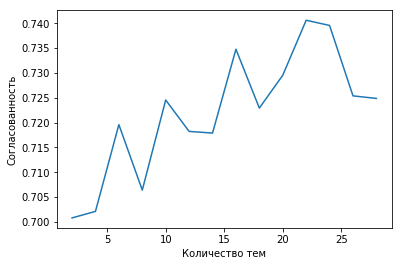

In [227]:
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.show()

Если судить по когерентности, наиболее оптимальное число тем - 22🤷🏻‍♂️

In [228]:
model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=22)
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data

/home/friday/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.065611 -0.022815       1        1  11.533977
10    -0.063500  0.051922       2        1   8.063204
8      0.038698 -0.016559       3        1   6.126573
17     0.010657 -0.048347       4        1   5.980330
13     0.040731  0.010048       5        1   5.915707
11     0.035731  0.030122       6        1   5.579046
18     0.016239 -0.000487       7        1   4.921168
6     -0.026602  0.002276       8        1   4.831296
16     0.010427 -0.008672       9        1   4.373429
12     0.003900  0.033471      10        1   4.246741
7      0.002497  0.010836      11        1   3.877827
14    -0.057137 -0.022905      12        1   3.809083
5     -0.040270 -0.018310      13        1   3.724990
19     0.008044 -0.037647      14        1   3.274791
0      0.045746 -0.011480      15        1   3.218906
21     0.011022 -0.003647      16        1   3.216104
4      0.003709  0.048096      17        1   3.150363
9      0.007511 -0.056279      18        1   3.112797
1     -0.006606  0.035563      19        1   2.979442
15    -0.004622 -0.011951      20        1   2.762683
20     0.024171  0.027746      21        1   2.756441
3      0.005264  0.009021      22        1   2.545105, topic_info=     Category        Freq                    Term       Total  loglift  \
term                                                                     
452   Default  819.000000              робот_NOUN  819.000000  30.0000   
21    Default  572.000000                ген_NOUN  572.000000  29.0000   
1322  Default  593.000000               мышь_NOUN  593.000000  28.0000   
2514  Default  345.000000            корабль_NOUN  345.000000  27.0000   
219   Default  459.000000          галактика_NOUN  459.000000  26.0000   
419   Default  524.000000           алгоритм_NOUN  524.000000  25.0000   
3182  Default  155.000000             комета_NOUN  155.000000  24.0000   
1798  Default  424.000000               дыра_NOUN  424.000000  23.0000   
744   Default  468.000000              черный_ADJ  468.000000  22.0000   
730   Default  399.000000            спутник_NOUN  399.000000  21.0000   
48    Default  454.000000               мозг_NOUN  454.000000  20.0000   
1076  Default  445.000000              белок_NOUN  445.000000  19.0000   
2859  Default  285.000000              вирус_NOUN  285.000000  18.0000   
2303  Default  513.000000             ракета_NOUN  513.000000  17.0000   
6     Default  352.000000                век_NOUN  352.000000  16.0000   
241   Default  213.000000            материя_NOUN  213.000000  15.0000   
27    Default  264.000000               днк_PROPN  264.000000  14.0000   
2289  Default  282.000000        истребитель_NOUN  282.000000  13.0000   
108   Default  295.000000               риск_NOUN  295.000000  12.0000   
40    Default  351.000000              кровь_NOUN  351.000000  11.0000   
428   Default  320.000000               дрон_NOUN  320.000000  10.0000   
555   Default  278.000000             запуск_NOUN  278.000000   9.0000   
185   Default  188.000000           растение_NOUN  188.000000   8.0000   
493   Default  243.000000             миссия_NOUN  243.000000   7.0000   
1641  Default  124.000000           кристалл_NOUN  124.000000   6.0000   
794   Default  112.000000                зуб_NOUN  112.000000   5.0000   
126   Default  255.000000           участник_NOUN  255.000000   4.0000   
1003  Default  227.000000           астероид_NOUN  227.000000   3.0000   
1583  Default  380.000000            пациент_NOUN  380.000000   2.0000   
527   Default  299.000000            станция_NOUN  299.000000   1.0000   
...       ...         ...                     ...         ...      ...   
1512  Topic22   13.024837            элемент_NOUN  213.519669   0.8741   
2440  Topic22    8.422005  продолжительность_NOUN  118.476364   1.0271   
1066  Topic22    7.694471              сосуд_NOUN  105.940697   1.0486 

In [239]:
model.show_topics()

[(14,
  '0.007*"белок_NOUN" + 0.006*"алгоритм_NOUN" + 0.005*"робот_NOUN" + 0.005*"кристалл_NOUN" + 0.005*"комета_NOUN" + 0.005*"спутник_NOUN" + 0.004*"изображение_NOUN" + 0.004*"самка_NOUN" + 0.003*"боеприпас_NOUN" + 0.003*"двигатель_NOUN"'),
 (2,
  '0.015*"робот_NOUN" + 0.007*"ракета_NOUN" + 0.007*"инженер_NOUN" + 0.006*"телескоп_NOUN" + 0.005*"черный_ADJ" + 0.004*"дрон_NOUN" + 0.004*"беспилотник_NOUN" + 0.004*"вертолет_NOUN" + 0.004*"теория_NOUN" + 0.003*"двигатель_NOUN"'),
 (17,
  '0.005*"магнитный_ADJ" + 0.004*"галактика_NOUN" + 0.004*"друг_NOUN" + 0.004*"физик_NOUN" + 0.003*"электрон_NOUN" + 0.003*"век_NOUN" + 0.003*"телескоп_NOUN" + 0.003*"солнечный_ADJ" + 0.003*"алгоритм_NOUN" + 0.003*"линия_NOUN"'),
 (15,
  '0.005*"станция_NOUN" + 0.004*"материя_NOUN" + 0.004*"темный_ADJ" + 0.003*"галактика_NOUN" + 0.003*"луна_PROPN" + 0.003*"растение_NOUN" + 0.003*"электрон_NOUN" + 0.003*"миссия_NOUN" + 0.003*"черный_ADJ" + 0.003*"мышь_NOUN"'),
 (12,
  '0.005*"белок_NOUN" + 0.004*"риск_NOUN" +

Кажется, что все категории перемешались. Можно отделить "технические" и "биологические" категории. Например, в категории 2 что-то про запуск беспилотников и спутников, категория 0 отвечает за генетику, категория 10 за оружие, 12 - за вирусологи.